# Test Evaluation with 150 Synthetic Graphs

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
#from open_spiel.python.algorithms import random_agent

import sys
sys.path.append("../")
from utils.reinforcement_learning.dqn import DQN
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
from utils.reinforcement_learning.rl_environment import Environment

evaluation, eval_x = get_Validation(50)
def CV_evaluation(model_path,parameter_loc):  
    params = Params(parameter_loc)
    file_list = []
    AUC = []
    x_label = []
    start = int(params.save_every)
    end = int(params.num_train_episodes)+start
    interval = int(params.save_every)
    for iteration in np.arange(start,end,interval):
        name = model_path+str(iteration)
        model = torch.load(name)
        auc_individual = []
        for i in range(len(evaluation)): 
            GRAPH = evaluation[i].copy()
            N = GRAPH.vcount()
            game = GraphGame
            env = Environment(game)
            attacker = DQN(state_representation_size=params.centrality_features,
                            hidden_layers_sizes= params.hidden_layers,
                           global_feature_size =params.global_features)
            attacker._q_network.load_state_dict(model["_q_network"])
            attacker._optimizer.load_state_dict(model["_optimizer"])
            rewards, lcc, actions = EvaluateModel(env, attacker,GRAPH)
            #Compute Area under the curve
            x =  np.flip(np.arange(N)[N:0:-1]/N)
            auc_individual.append(area_under_curve(x[:len(lcc)],lcc))
        AUC.append(np.mean(auc_individual))
        x_label.append(iteration)
    AUC = np.array(AUC)
    x_label = np.array(x_label)
    return x_label, AUC

# Results: Thompson Sampling

In [10]:
from tqdm import tqdm
#path = "./model/DiffSize_Different_Graph/model_differentGraph_"
model_path = ["../model/DiffSize_BA_Graph_TS/model_BAGraph_","../model/DiffSize_Different_Graph_TS/model_differentGraph_"]
parameters = ["../utils/ba_params.json","../utils/mixed_params.json"]
results = []
for path in tqdm(range(2)):
    x, value = CV_evaluation(model_path[path],parameters[path])
    results.append([x,value])


100%|█████████████████████████████████████████| 2/2 [1:51:49<00:00, 3354.69s/it]


In [11]:
def lowest_AUC(x,value):
    lowest_auc_index = np.argmin(value)
    return x[lowest_auc_index], value[lowest_auc_index]
results = np.array(results)
print(results.shape)     
print("BA Graph")
print(lowest_AUC(results[0,0,:],results[0,1,:]))
print("Different Graph")
print(lowest_AUC(results[1,0,:],results[1,1,:]))

(2, 2, 1000)
BA Graph
(295500.0, 6.301956357708783)
Different Graph
(212500.0, 6.275631773604836)


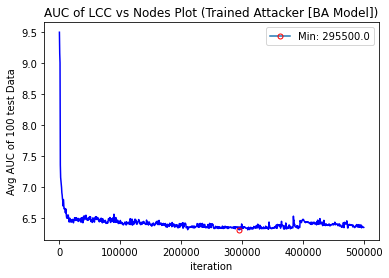

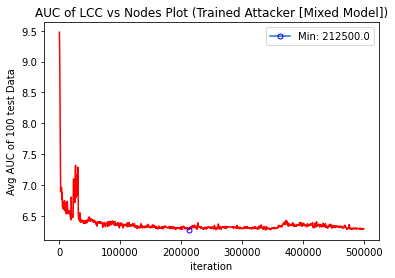

In [12]:
for j in range(2):
    if j == 0:
        color = 'blue'
        inv = 'red'
    else:
        color = 'red'
        inv = 'blue'
    if j == 0:
        name = "(Trained Attacker [BA Model])"
        save = "BA"
        
    else:
        name = "(Trained Attacker [Mixed Model])"
        save = "Diff"                    
    min_vc, min_value = lowest_AUC(results[j,0,:],results[j,1,:])
    plt.plot(results[j,0,:],results[j,1,:], color)
    plt.plot(min_vc, min_value, marker="o", markersize=5, markeredgecolor=inv, markerfacecolor="None",label="Min: "+str(min_vc))
    plt.title("AUC of LCC vs Nodes Plot "+""+str(name)) 
    plt.xlabel("iteration")
    plt.ylabel("Avg AUC of 100 test Data")
    plt.legend()
    plt.savefig("./Figure/Validation/Test_TS_100_"+save)
    plt.show()
        

# Results: Random Greedy

In [14]:
from tqdm import tqdm
#path = "./model/DiffSize_Different_Graph/model_differentGraph_"
model_path = ["../model/DiffSize_BA_Graph/model_BAGraph_","../model/DiffSize_Different_Graph/model_differentGraph_"]
parameters = ["../utils/ba_params.json","../utils/mixed_params.json"]
results = []
for path in tqdm(range(2)):
    x, value = CV_evaluation(model_path[path],parameters[path])
    results.append([x,value])


100%|█████████████████████████████████████████| 2/2 [2:52:58<00:00, 5189.22s/it]


In [15]:
def lowest_AUC(x,value):
    lowest_auc_index = np.argmin(value)
    return x[lowest_auc_index], value[lowest_auc_index]
results = np.array(results)
print(results.shape)     
print("BA Graph")
print(lowest_AUC(results[0,0,:],results[0,1,:]))
print("Different Graph")
print(lowest_AUC(results[1,0,:],results[1,1,:]))

(2, 2, 1000)
BA Graph
(349000.0, 10.160434631750423)
Different Graph
(111500.0, 8.519558351109387)


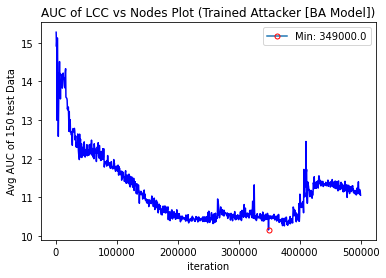

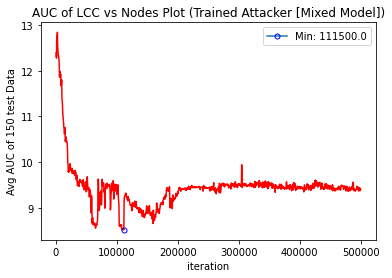

In [16]:
for j in range(2):
    if j == 0:
        color = 'blue'
        inv = 'red'
    else:
        color = 'red'
        inv = 'blue'
    if j == 0:
        name = "(Trained Attacker [BA Model])"
        save = "BA"
        
    else:
        name = "(Trained Attacker [Mixed Model])"
        save = "Diff"                    
    min_vc, min_value = lowest_AUC(results[j,0,:],results[j,1,:])
    plt.plot(results[j,0,:],results[j,1,:], color)
    plt.plot(min_vc, min_value, marker="o", markersize=5, markeredgecolor=inv, markerfacecolor="None",label="Min: "+str(min_vc))
    plt.title("AUC of LCC vs Nodes Plot "+""+str(name)) 
    plt.xlabel("iteration")
    plt.ylabel("Avg AUC of 150 test Data")
    plt.legend()
    plt.savefig("./Figure/Validation/Test_Rand_100_"+save)
    plt.show()
        

## Feature of the Evaluation Dataset

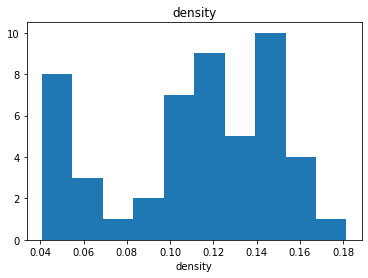

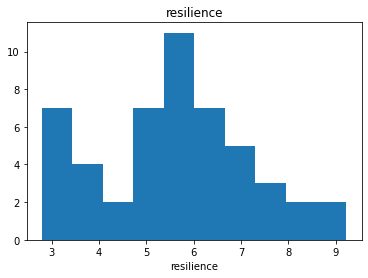

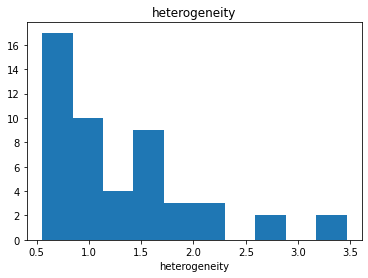

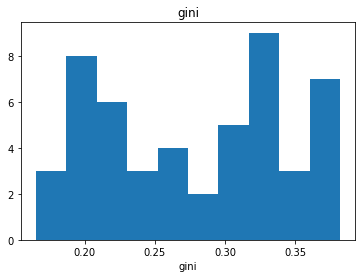

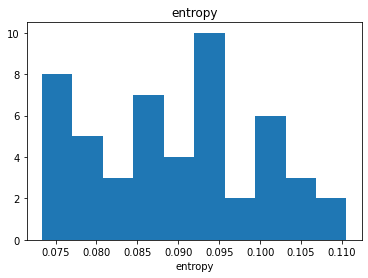

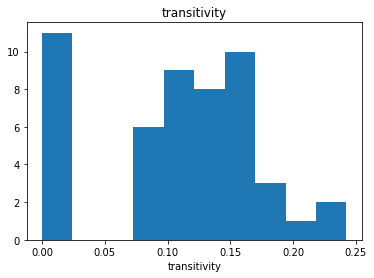

In [17]:
from scipy.stats import entropy
def globalfeature(g): 
    subGraph = g.to_networkx()
    M = len(subGraph.edges())
    N = len(subGraph)
    degs =   np.array(subGraph.degree())[:,1]
    k1 = degs.mean()
    k2 = np.mean(degs** 2)
    div = k2 - k1**2
    if k1 != 0:
        heterogeneity = div/k1
        density = (2*M)/(N*(N-1))
        resilience = k2/k1
        sorted_degs = sorted(degs)
        gini = sum([(i+1) * sorted_degs[i] for i in range(N)])/(M*N) - (N+1)/N
        entrop = entropy(degs/M)/N
        transitivity = nx.algorithms.cluster.transitivity(subGraph)
    else:
        heterogeneity = 0
        density = (2*M)/(N*(N-1))
        resilience = 0
        gini = 0
        entrop = 0
        transitivity = nx.algorithms.cluster.transitivity(subGraph)
    global_properties = np.hstack((density,resilience,heterogeneity,gini,entrop,transitivity))
    #global_properties = np.hstack((density,resilience,heterogeneity))
    return global_properties
feature = []
for g in evaluation:
    feature.append(globalfeature(g))
feature = np.array(feature)
label = ['density','resilience','heterogeneity','gini','entropy','transitivity']
for i in range(feature.shape[1]):
    plt.hist(feature[:,i])
    plt.title(label[i])
    plt.xlabel(label[i])
    #plt.savefig("./Cross_Validation/Validation/Histogram_200_"+label[i])
    plt.show()